# Fourier Neural Operator 1D

## Burgers equation

---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pprint import pprint

from fourier_1d_for_nb import SpectralConv1d, FNO1d


Matplotlib is building the font cache; this may take a moment.


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [4]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

In [6]:
torch.manual_seed(0)
np.random.seed(0)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device=='cuda':
    torch.cuda.set_device(2)
    

Using device: cuda


In [8]:
print("How many GPUs are there?")
print(torch.cuda.device_count())

print("Which GPU Is The Current GPU?")
print(torch.cuda.current_device())

print("Get the name of the current GPU")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

How many GPUs are there?
4
Which GPU Is The Current GPU?
0
Get the name of the current GPU
TITAN X (Pascal)


# Hyperparamètres

In [29]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 16
width = 64

## Loading Data

In [30]:
################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/burgers_data_R10.mat')
x_data = dataloader.read_field('a')[:,::sub]
y_data = dataloader.read_field('u')[:,::sub]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]


In [31]:
x_train.shape

torch.Size([1000, 1024])

In [32]:
x_train

tensor([[ 0.8354,  0.8348,  0.8340,  ...,  0.8364,  0.8362,  0.8359],
        [ 0.4741,  0.4723,  0.4707,  ...,  0.4804,  0.4781,  0.4760],
        [-0.3802, -0.3849, -0.3898,  ..., -0.3669, -0.3711, -0.3756],
        ...,
        [ 0.0938,  0.0969,  0.1002,  ...,  0.0856,  0.0882,  0.0909],
        [ 0.4329,  0.4335,  0.4340,  ...,  0.4302,  0.4312,  0.4321],
        [-0.5274, -0.5289, -0.5305,  ..., -0.5228, -0.5243, -0.5259]])

In [33]:

# cat the locations information
grid = np.linspace(0, 1, s).reshape(1, s, 1)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,1), grid.repeat(ntrain,1,1)], dim=2)
x_test = torch.cat([x_test.reshape(ntest,s,1), grid.repeat(ntest,1,1)], dim=2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [34]:
grid

tensor([[[0.0000e+00],
         [9.7752e-04],
         [1.9550e-03],
         ...,
         [9.9804e-01],
         [9.9902e-01],
         [1.0000e+00]]])

In [35]:
grid.shape

torch.Size([1, 1024, 1])

In [36]:
x_data.shape

torch.Size([2048, 1024])

In [37]:
y_data.shape

torch.Size([2048, 1024])

In [38]:
x_train.shape

torch.Size([1000, 1024, 2])

In [39]:
x_test.shape

torch.Size([100, 1024, 2])

In [40]:
y_train.shape

torch.Size([1000, 1024])

In [41]:
y_test.shape

torch.Size([100, 1024])

In [42]:
# model
model = FNO1d(modes, width).to(device)
print(count_params(model))

287425


## Training

In [43]:
################################################################
# training and evaluation
################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [44]:
list_train_mse = []
list_train_l2 = []
list_test_l2 = []


myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        # mse.backward()
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)
    list_train_mse.append(train_mse)
    list_train_l2.append(train_l2)
    list_test_l2.append(test_l2)
    
    
    
    
# Getting the predictions tensor on the test set

# # torch.save(model, 'model/ns_fourier_burgers')
# pred = torch.zeros(y_test.shape)
# index = 0
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
# with torch.no_grad():
#     for x, y in test_loader:
#         test_l2 = 0
#         x, y = x.to(device), y.to(device)

#         out = model(x)
#         pred[index] = out

#         test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         print(index, test_l2)
#         index = index + 1

# # scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})


0 0.5069165909662843 0.05535144121386111 0.3687670599222183 0.0979593551158905
1 0.48051705677062273 0.0017697135027265175 0.0773246414065361 0.05735758543014526
2 0.47990712616592646 0.0007819609466241672 0.055258169293403624 0.05458024680614471
3 0.46686467807739973 0.0008108250092482194 0.05674617546796799 0.06898830413818359
4 0.4924375992268324 0.0005450633652799297 0.04335533916950226 0.043307936787605285
5 0.47636034712195396 0.0006569653062615543 0.053410497605800626 0.04837075293064117
6 0.47583069559186697 0.0006001377184293232 0.05012488305568695 0.03130221784114837
7 0.46995523292571306 0.0004447822817019187 0.043677083134651185 0.03182111382484436
8 0.47988741286098957 0.00032247348353848794 0.033921658843755725 0.028505715131759642
9 0.48453535325825214 0.0002487673900759546 0.028899675339460373 0.026692379713058472
10 0.4742879718542099 0.00025489137646218297 0.029805803775787353 0.030433871746063233
11 0.4878228744491935 0.00023064667751896195 0.029028793036937714 0.024

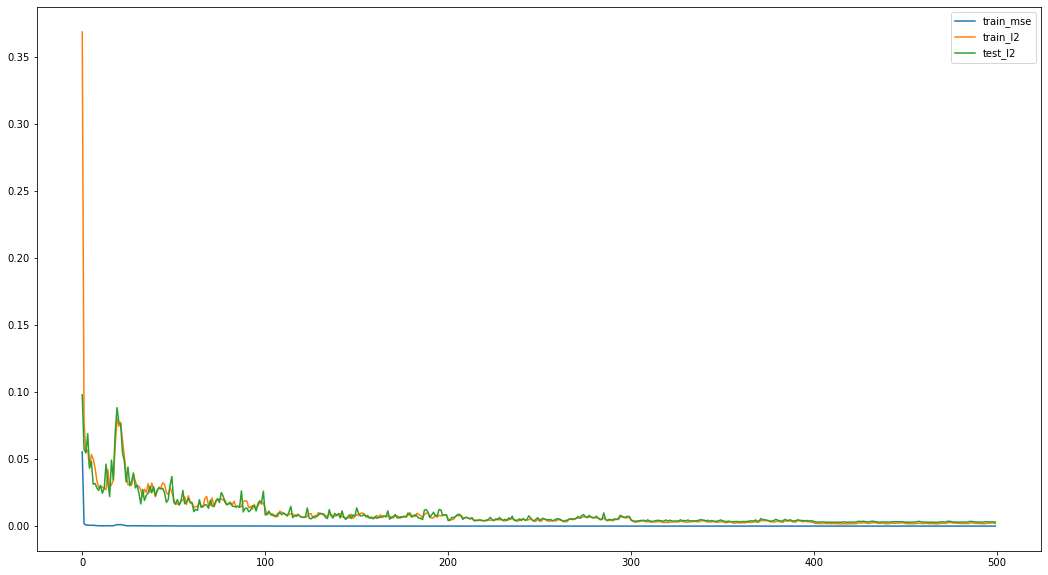

In [45]:
fig = plt.figure(figsize=(18, 10))

to_plot_list = list(zip(('train_mse', 'train_l2', 'test_l2'), (list_train_mse, list_train_l2, list_test_l2)) )
for couple in to_plot_list:
    couple_label, couple_data = couple
    plt.plot(couple_data, label=couple_label)
plt.legend()
plt.show()